# Get Kd monthly

In [1]:
 import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

In [6]:
results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_KD",
    temporal = ("2024-02-01", "2025-09-30"),
    granule_name="*.MO.*.0p1deg.*"
)
len(results)

14

In [7]:
paths = earthaccess.open(results);

QUEUEING TASKS | :   0%|          | 0/14 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/14 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/14 [00:00<?, ?it/s]

In [17]:
import xarray as xr
import pandas as pd
import re

# 1. Extract time from the file names
def extract_start_date(path_obj):
    fname = path_obj.path if hasattr(path_obj, "path") else str(path_obj)
    match = re.search(r'PACE_OCI\.(\d{8})_', fname)
    if match:
        return pd.to_datetime(match.group(1), format="%Y%m%d")
    else:
        raise ValueError(f"Could not extract date from: {fname}")

times = [extract_start_date(p) for p in paths]

In [18]:
# 2. Open and stack the datasets
combined = xr.open_mfdataset(
    paths,
    combine='nested',
    concat_dim='time'
)

# 3. Assign the time coordinate explicitly
combined = combined.assign_coords(time=("time", times))


In [19]:
combined

<xarray.Dataset> Size: 7GB
Dimensions:     (time: 14, lat: 1800, lon: 3600, wavelength: 19, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 152B 351.0 361.0 385.0 ... 678.0 711.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * time        (time) datetime64[ns] 112B 2024-03-01 2024-04-01 ... 2025-04-01
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Kd          (time, lat, lon, wavelength) float32 7GB dask.array<chunksize=(1, 16, 1024, 8), meta=np.ndarray>
    palette     (time, rgb, eightbitcolor) uint8 11kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240301_20240331.L3m.MO.KD.V...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/KD/3.0
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3010346
    data_minimum:                      0.015999997
    data_maximum:                      6.000002

In [75]:
ds = combined.sel(
    lat=slice(30,10),  # descending lat
    lon=slice(-25,-10)              # ascending lon
)

In [38]:
Kd_490 = ds["Kd"].sel(wavelength=490.0)
Kd_490 = Kd_490.squeeze()

In [39]:
print(Kd_490)

<xarray.DataArray 'Kd' (time: 14, lat: 200, lon: 150)> Size: 2MB
dask.array<getitem, shape=(14, 200, 150), dtype=float32, chunksize=(1, 16, 150), chunktype=numpy.ndarray>
Coordinates:
    wavelength  float64 8B 490.0
  * lat         (lat) float32 800B 29.95 29.85 29.75 29.65 ... 10.25 10.15 10.05
  * lon         (lon) float32 600B -24.95 -24.85 -24.75 ... -10.25 -10.15 -10.05
  * time        (time) datetime64[ns] 112B 2024-03-01 2024-04-01 ... 2025-04-01
Attributes:
    long_name:      Diffuse attenuation coefficient
    units:          m^-1
    valid_min:      50
    valid_max:      30000
    reference:      Lee, Z.P., M. Darecki, K.L. Carder, C.O.Davis, D. Stramsk...
    display_scale:  log
    display_min:    0.01
    display_max:    5.0


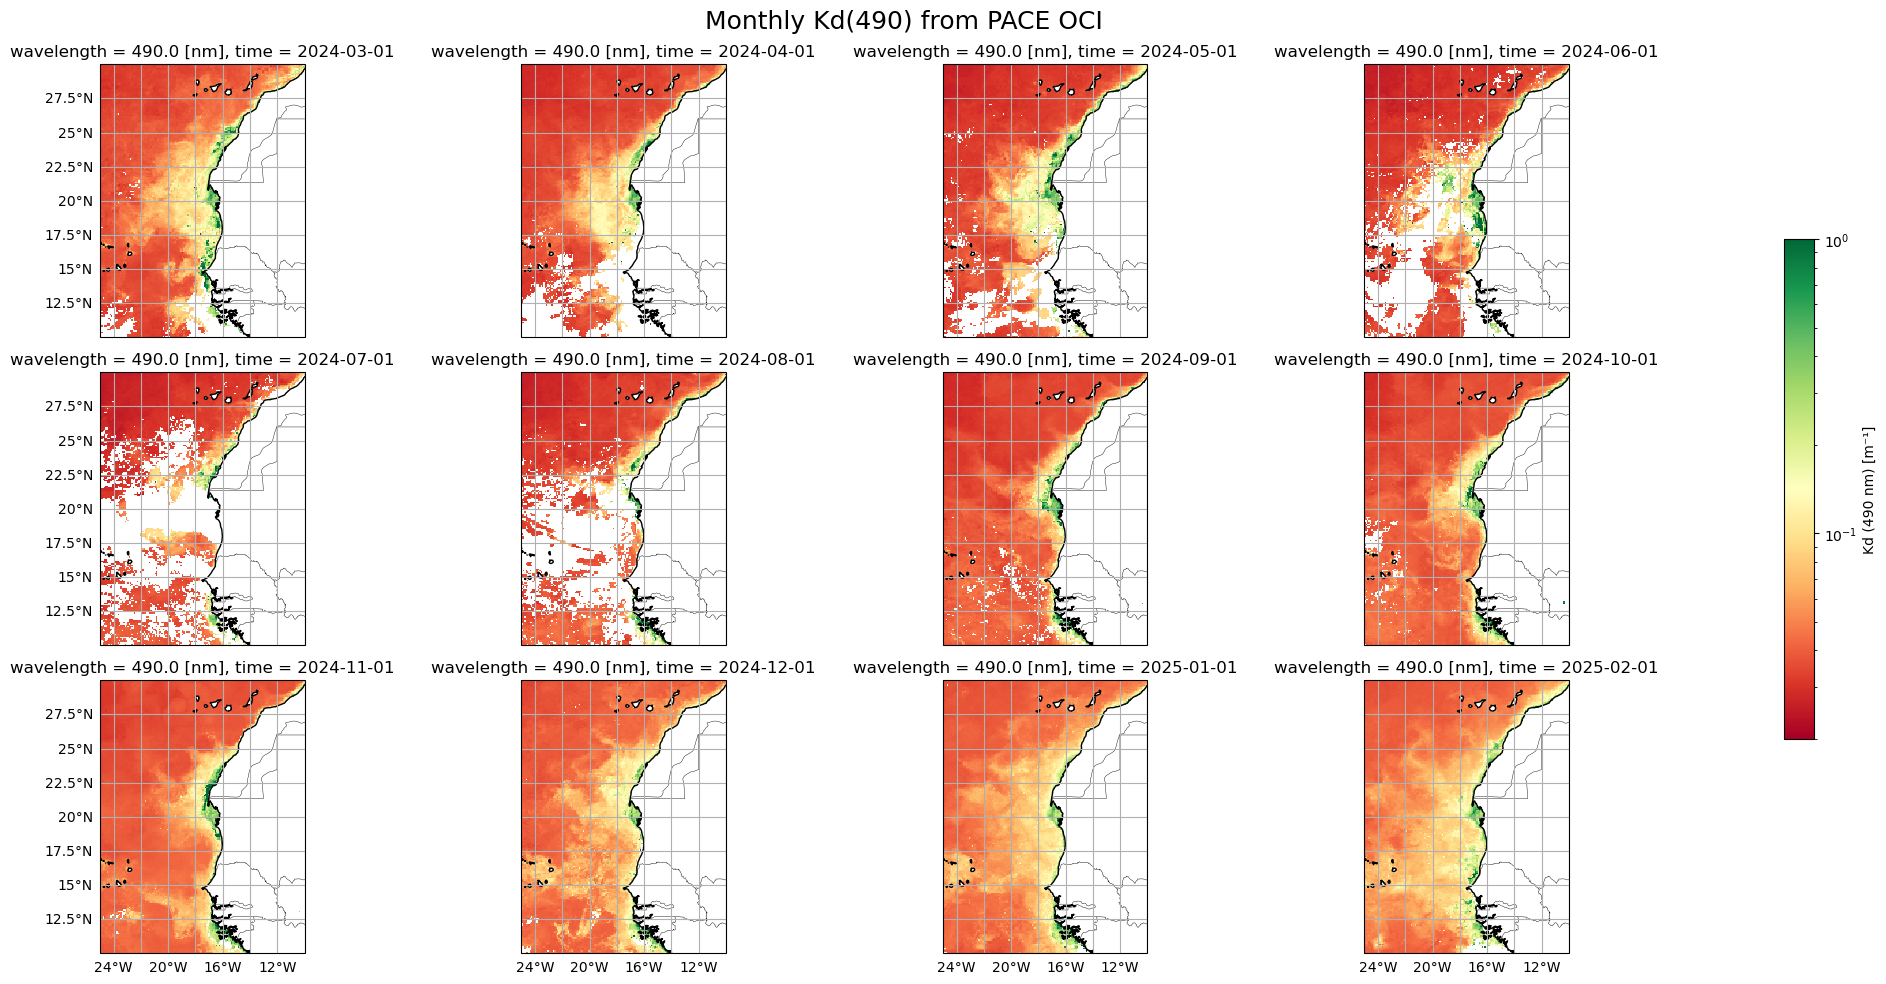

In [70]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
import pandas as pd
from matplotlib.colors import LogNorm

# ---- Settings ----
variable = "Kd_490"
ds = Kd_490  # this is your DataArray

# ---- Create figure and axes ----
fig, axs = plt.subplots(3, 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

# ---- Loop over months ----
for i, ax in enumerate(axs):
        month_data = ds.isel(time=i)

        # Extract readable title
        date_str = pd.to_datetime(str(month_data.time.values)).strftime("%B %Y")
        ax.set_title(date_str)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = gl.right_labels = False
        gl.bottom_labels = i > 7
        gl.left_labels = i % 4 == 0
        gl.right_labels = False

        img = month_data.plot(
            ax=ax,
            cmap="RdYlGn",
            norm=LogNorm(vmin=0.02, vmax=1.0),
            robust=True,
            add_colorbar=False
        )

# ---- Add colorbar to the right of the figure ----
# Create a colorbar axis to the right of the subplots
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make space for the colorbar
plt.tight_layout(rect=[0, 0, 0.93, 0.96])  # leave space on right

# Create a new axis for the colorbar
cbar_ax = fig.add_axes([0.94, 0.25, 0.015, 0.5])  # [left, bottom, width, height] in figure coords

# Use the last image handle for colorbar
fig.colorbar(img, cax=cbar_ax, label="Kd (490 nm) [m⁻¹]")

plt.suptitle("Monthly Kd(490) from PACE OCI", fontsize=18)
plt.show()


In [93]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from matplotlib.colors import LogNorm

def plot_kd_monthly_maps(ds, wavelength, vmin=0.02, vmax=1.0, cmap="RdYlGn"):
    """
    Plot monthly Kd maps for a given wavelength from a PACE OCI dataset.

    Parameters:
    - ds: xarray.Dataset containing the variable "Kd" with dimensions (time, lat, lon, wavelength)
    - wavelength: float, the wavelength (in nm) to plot (e.g. 490.0)
    - vmin, vmax: float, limits for color scale (useful with log scaling)
    - cmap: str, colormap name (default is "RdYlGn")
    """
    da = ds["Kd"].sel(wavelength=wavelength, method="nearest").squeeze()

    fig, axs = plt.subplots(3, 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        if i < len(da.time):
            month_data = da.isel(time=i)
            date_str = pd.to_datetime(str(month_data.time.values)).strftime("%B %Y")
            ax.set_title(date_str)

            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linewidth=0.3)
            gl = ax.gridlines(draw_labels=True)
            gl.top_labels = gl.right_labels = False
            gl.bottom_labels = i > 7
            gl.left_labels = i % 4 == 0
            gl.right_labels = False

            img = month_data.plot(
                ax=ax,
                cmap=cmap,
                #norm=LogNorm(vmin=vmin, vmax=vmax),
                robust=True,
                add_colorbar=False,
                add_labels=False
            )
        else:
            ax.set_visible(False)

    # Adjust layout to make room for colorbar
    plt.tight_layout(rect=[0, 0, 0.93, 0.96])

    # Add colorbar on the right
    cbar_ax = fig.add_axes([0.94, 0.25, 0.015, 0.5])
    cbar = fig.colorbar(img, cax=cbar_ax)

    # Set font sizes
    cbar.ax.tick_params(labelsize=20)  # tick labels
    cbar.set_label(f"Kd ({int(wavelength)} nm) [m⁻¹]", fontsize=16)  # axis label

    plt.suptitle(f"Monthly Kd({int(wavelength)}) from PACE OCI", fontsize=18)
    plt.show()


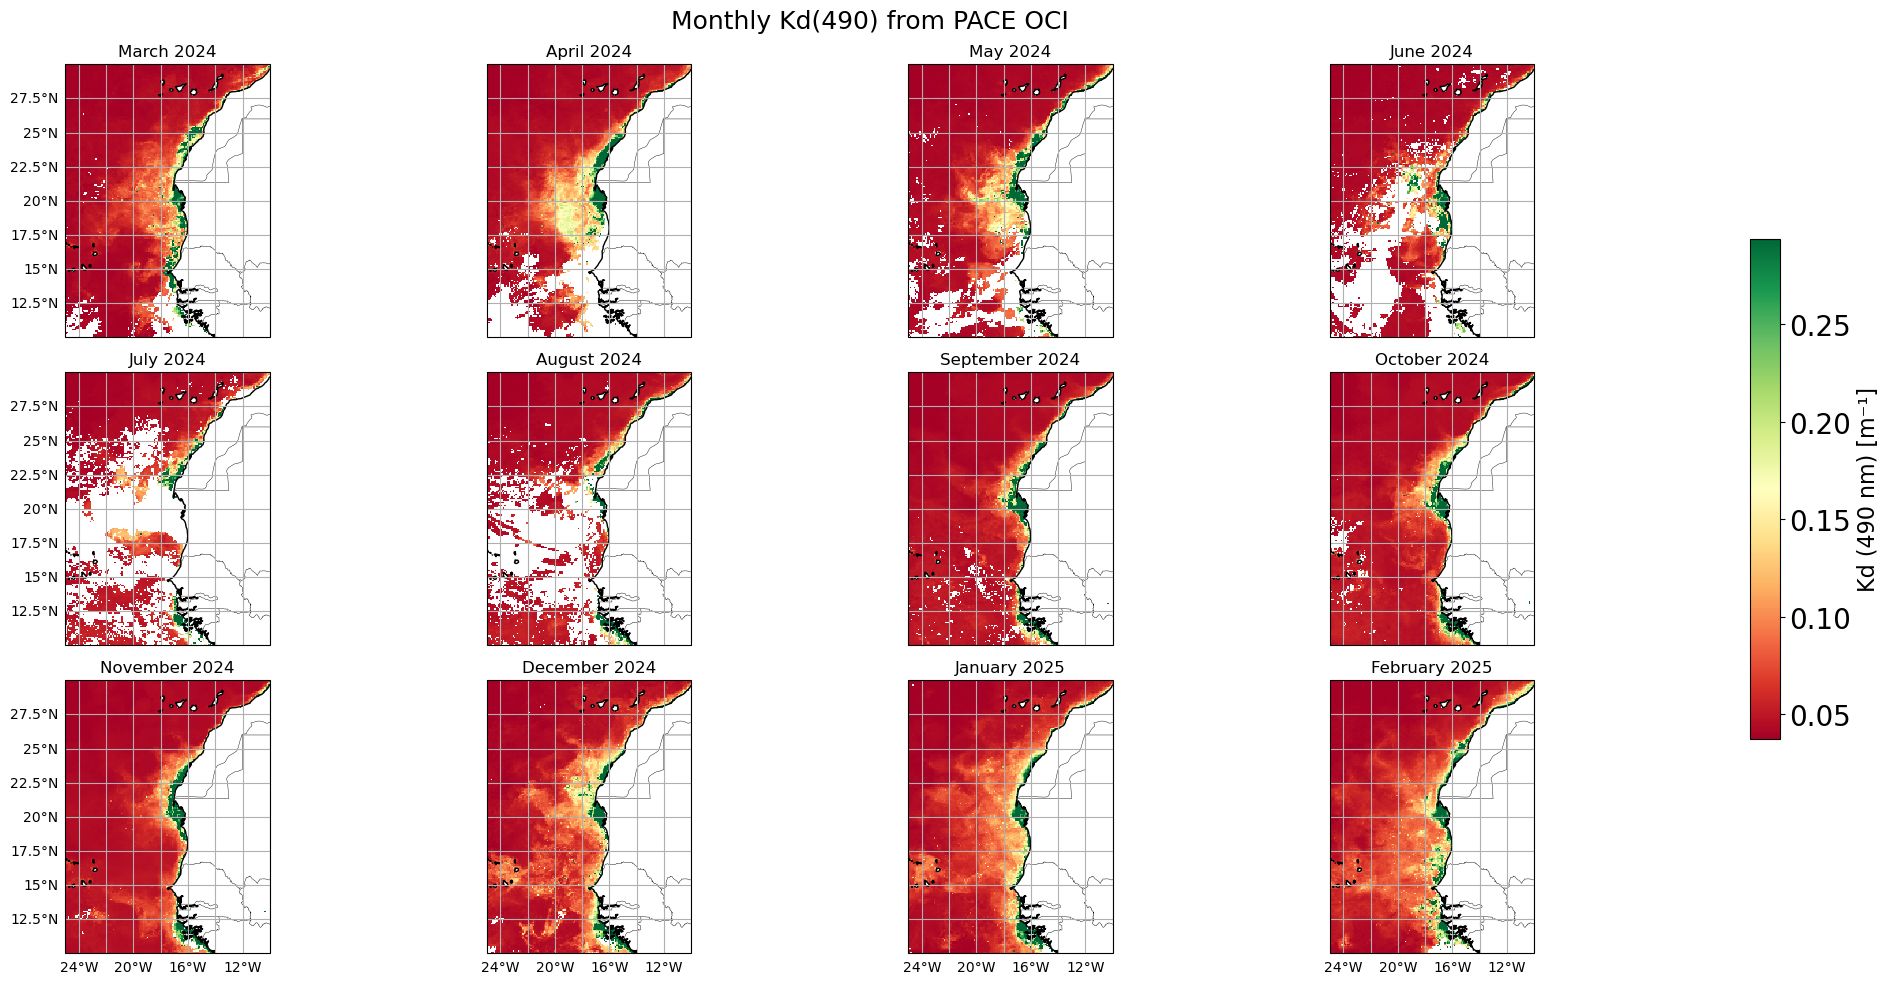

In [94]:
plot_kd_monthly_maps(ds, 490)

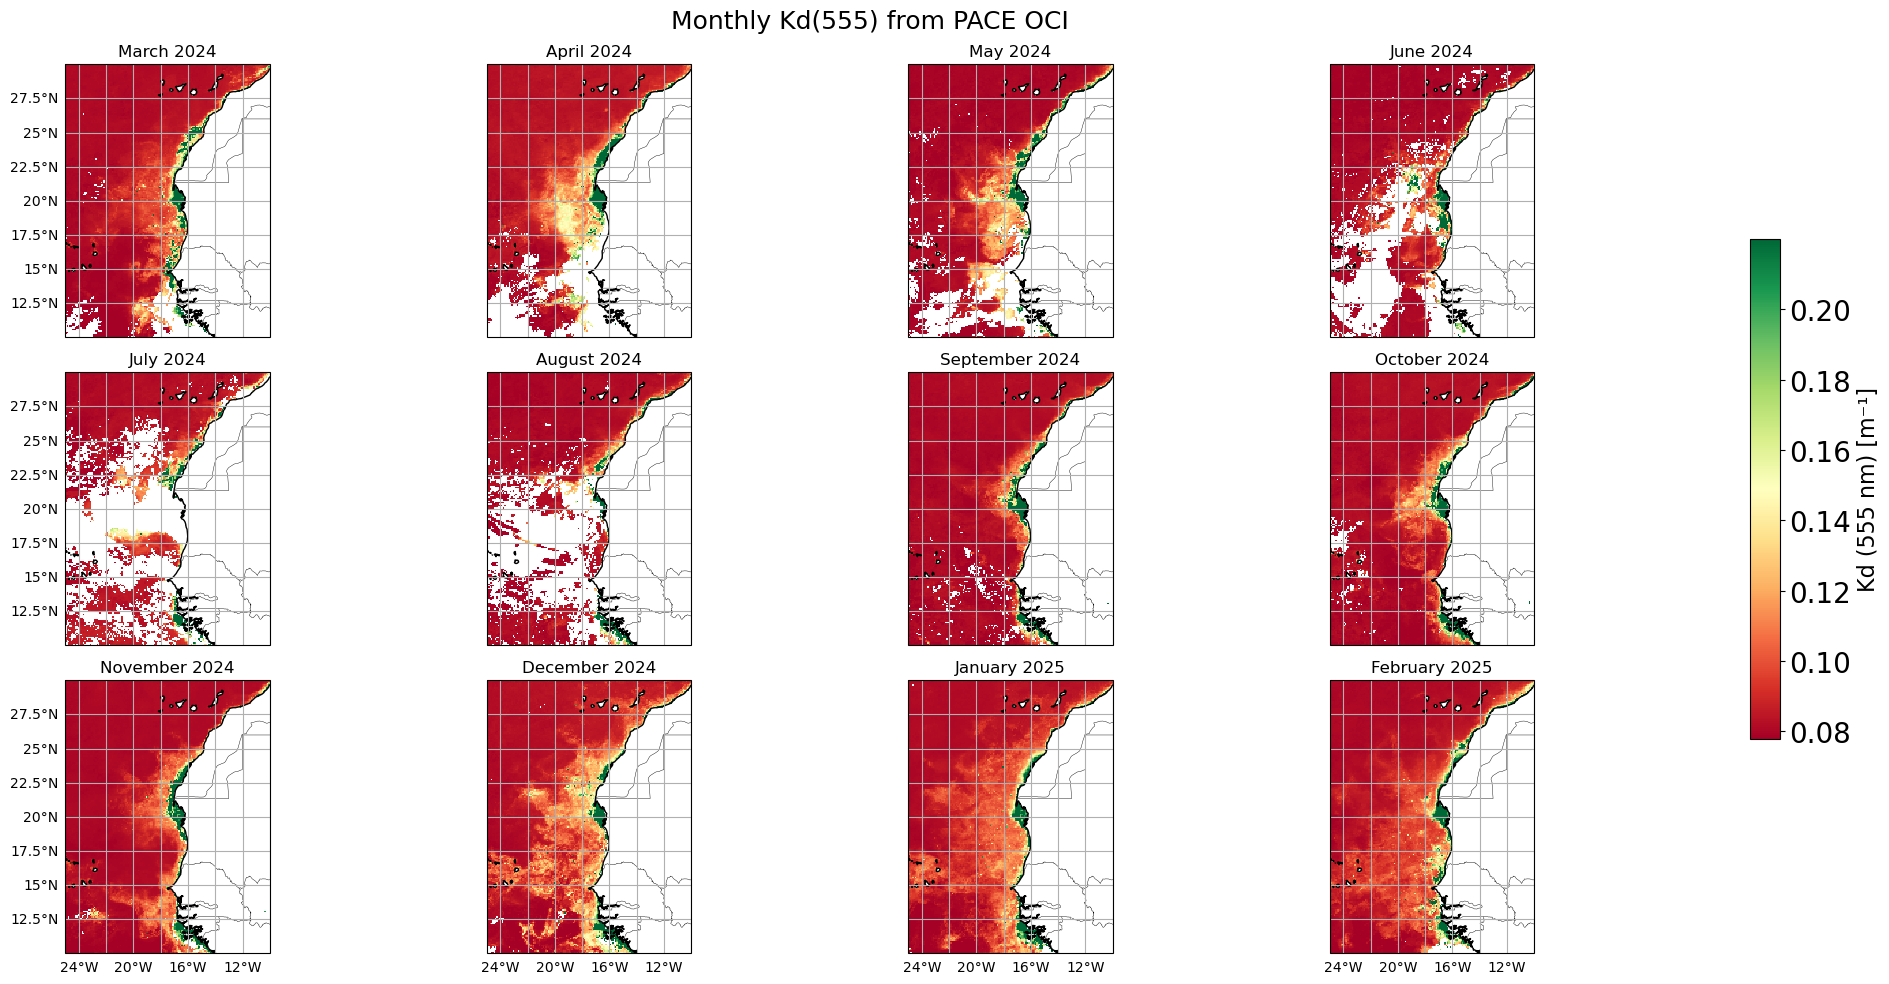

In [95]:
plot_kd_monthly_maps(ds, 555)

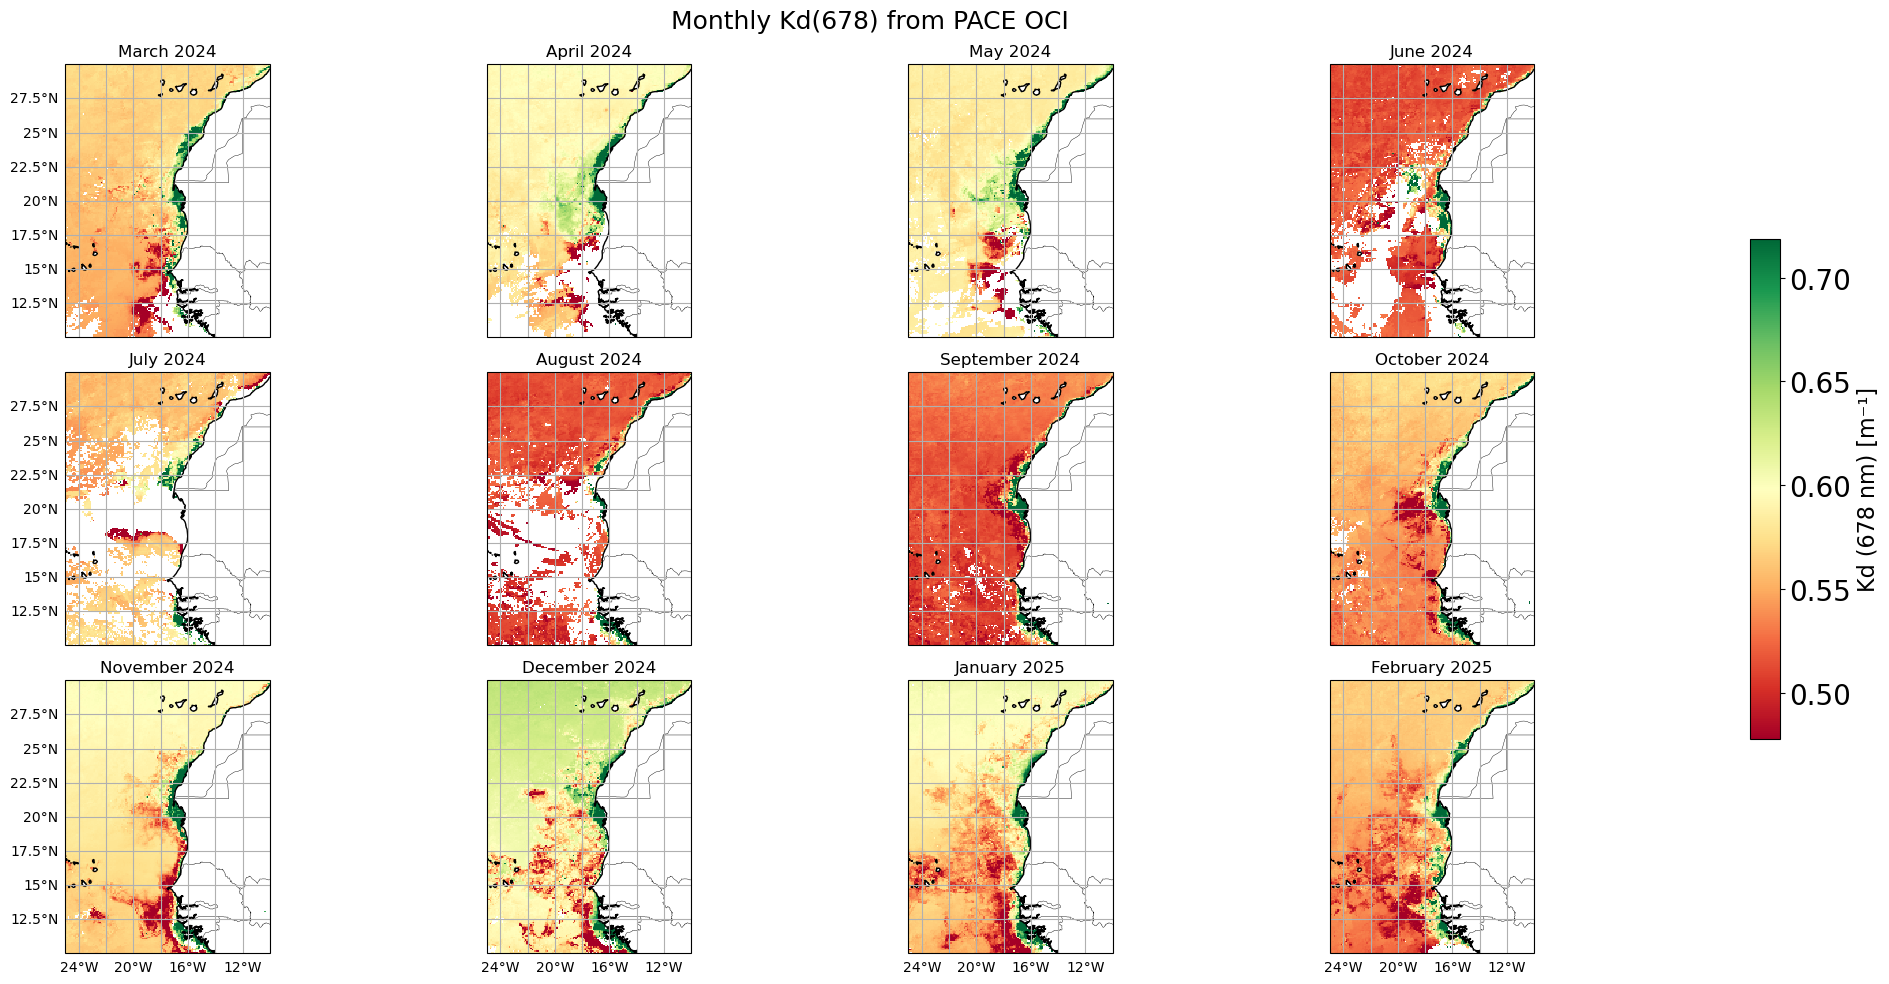

In [96]:
plot_kd_monthly_maps(ds, 678)